Epoch 1/10, Loss: 3.0483
Epoch 2/10, Loss: 2.9805
Epoch 3/10, Loss: 2.9185
Epoch 4/10, Loss: 2.8598
Epoch 5/10, Loss: 2.8028
Epoch 6/10, Loss: 2.7459
Epoch 7/10, Loss: 2.6876
Epoch 8/10, Loss: 2.6262
Epoch 9/10, Loss: 2.5605
Epoch 10/10, Loss: 2.4895

Input: 'the cat' → Predicted next word: 'sat'


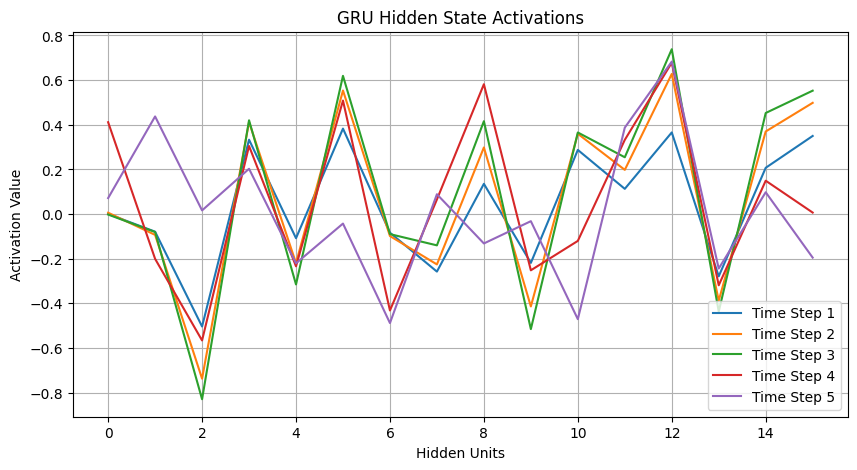

In [ ]:
# 1. IMPORTS AND TOY DATA
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Toy sentences (corpus)
corpus = [
    "the cat sat on the mat",
    "the dog barked loudly",
    "a man is walking",
    "she is reading a book",
    "they are playing in the garden"
]
# -----------------------------------------------

# 2. TOKENIZATION & SEQUENCING
tokens = [sentence.split() for sentence in corpus]
all_words = sorted(set(word for sentence in tokens for word in sentence))
word2idx = {w: i for i, w in enumerate(all_words)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx)

# Create input-output sequences
sequences = []
for sentence in tokens:
    for i in range(1, len(sentence)):
        input_seq = sentence[:i]
        target = sentence[i]
        sequences.append((
            [word2idx[word] for word in input_seq],
            word2idx[target]
        ))

# Padding
max_len = max(len(seq[0]) for seq in sequences)
X = []
y = []
for seq, target in sequences:
    padded = [0] * (max_len - len(seq)) + seq
    X.append(padded)
    y.append(target)

X = torch.tensor(X)
y = torch.tensor(y)
# -----------------------------------------------

# 3. DEFINE GRU MODEL
class GRUNextWordModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUNextWordModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)                        # Embedding layer
        output, _ = self.gru(x)                  # GRU layer
        final_output = self.fc(output[:, -1, :]) # Only last hidden state for prediction
        return final_output, output              # Return full outputs for visualization

# Hyperparameters
embedding_dim = 10
hidden_dim = 16
model = GRUNextWordModel(vocab_size, embedding_dim, hidden_dim)
# -----------------------------------------------

# 4. TRAINING LOOP
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output, _ = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/10, Loss: {loss.item():.4f}")
# -----------------------------------------------

# 5. NEXT WORD PREDICTION FUNCTION
def predict_next_word(model, input_text):
    model.eval()
    words = input_text.split()
    input_seq = [word2idx.get(w, 0) for w in words]
    padded = [0] * (max_len - len(input_seq)) + input_seq
    x = torch.tensor([padded])
    with torch.no_grad():
        out, _ = model(x)
        pred_idx = torch.argmax(out, dim=1).item()
    return idx2word[pred_idx]

# Test
input_phrase = "the cat"
predicted = predict_next_word(model, input_phrase)
print(f"\nInput: '{input_phrase}' → Predicted next word: '{predicted}'")
# -----------------------------------------------

# 6. HIDDEN STATE VISUALIZATION
model.eval()
with torch.no_grad():
    test_words = input_phrase.split()
    test_seq = [word2idx.get(w, 0) for w in test_words]
    test_padded = [0] * (max_len - len(test_seq)) + test_seq
    x = torch.tensor([test_padded])
    _, hidden_states = model(x)                 # hidden_states: [1, seq_len, hidden_dim]
    hidden_states = hidden_states.squeeze(0).numpy()  # remove batch dimension

# Plot hidden states at each time step
plt.figure(figsize=(10, 5))
for i, hs in enumerate(hidden_states):
    plt.plot(hs, label=f"Time Step {i+1}")
plt.title("GRU Hidden State Activations")
plt.xlabel("Hidden Units")
plt.ylabel("Activation Value")
plt.legend()
plt.grid(True)
plt.show()
